# Natural Language Processing

## Part 1: TorchText + LSTM + Teaching Forcing


In this first notebook, we'll start simple to understand the general seq2seq concepts by implementing the model from the [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215) paper. This will be done on German to English translations, but the models can be applied to any problem that involves going from one sequence to another, such as summarization.

The figures are from https://github.com/bentrevett.

**Note**:  In this series of tutorials, I am too lazy to put `batch_size` as first dimension (i.e., `batch_first=True`, thus the shape of sentence will be `(seq len, batch size)` instead of `(batch size, seq len)`.  If you want to see how `batch_first` works, look at the `classification` folder.

### Introduction

The most common sequence-to-sequence (seq2seq) models are *encoder-decoder* models, which *encode* the source (input) sentence into a single vector we called *context vector*. We can think of the context vector as being an abstract representation of the entire input sentence. This vector is then *decoded* by a second RNN which learns to output the target (output) sentence by generating it one word at a time.

<img src = "figures/seq2seq1.png" width="500">
            
The above image shows an example translation. The input/source sentence, "guten morgen", is passed through the embedding layer (yellow) and then input into the encoder (green). 

We also append a *start of sequence* (`<sos>`) and *end of sequence* (`<eos>`) token to the start and end of sentence, respectively. At each time-step, the input to the encoder RNN is both the embedding, $e$, of the current word, $e(x_t)$, as well as the hidden state from the previous time-step, $h_{t-1}$, and the encoder RNN outputs a new hidden state $h_t$. We can think of the hidden state as a vector representation of the sentence so far. The RNN can be represented as a function of both of $e(x_t)$ and $h_{t-1}$:

$$h_t = \text{EncoderRNN}(e(x_t), h_{t-1})$$

We're using the term RNN generally here, it could be any recurrent architecture, such as an *LSTM* (Long Short-Term Memory) or a *GRU* (Gated Recurrent Unit). Here, we have $X = \{x_1, x_2, ..., x_T\}$, where $x_1 = \text{<sos>}, x_2 = \text{guten}$, etc. The initial hidden state, $h_0$, is usually either initialized to zeros or a learned parameter.

Once the final word, $x_T$, has been passed into the RNN, we use the final hidden state, $h_T$, as the context vector, i.e. $h_T = z$. This is a vector representation of the entire source sentence.

Now we have our context vector, $z$, we can start decoding it to get the output/target sentence, "good morning". Again, we append start and end of sequence tokens to the target sentence. At each time-step, the input to the decoder RNN (blue) is the embedding, $d$, of current word, $d(y_t)$, as well as the hidden state from the previous time-step, $s_{t-1}$, where the initial decoder hidden state, $s_0$, is the context vector, $s_0 = z = h_T$, i.e. the initial decoder hidden state is the final encoder hidden state. Thus, similar to the encoder, we can represent the decoder as:

$$s_t = \text{DecoderRNN}(d(y_t), s_{t-1})$$

Although the input/source embedding layer, $e$, and the output/target embedding layer, $d$, are both shown in yellow in the diagram they are two different embedding layers with their own parameters.

In the decoder, we need to go from the hidden state to an actual word, therefore at each time-step we use $s_t$ to predict (by passing it through a `Linear` layer, shown in purple) what we think is the next word in the sequence, $\hat{y}_t$. 

$$\hat{y}_t = f(s_t)$$

The words in the decoder are always generated one after another, with one per time-step. We always use `<sos>` for the first input to the decoder, $y_1$, but for subsequent inputs, $y_{t>1}$, we will sometimes use the actual, ground truth next word in the sequence, $y_t$ and sometimes use the word predicted by our decoder, $\hat{y}_{t-1}$. This is called **teacher forcing**. 

When training/testing our model, we always know how many words are in our target sentence, so we stop generating words once we hit that many. During inference it is common to keep generating words until the model outputs an `<eos>` token or after a certain amount of words have been generated.

Once we have our predicted target sentence, $\hat{Y} = \{ \hat{y}_1, \hat{y}_2, ..., \hat{y}_T \}$, we compare it against our actual target sentence, $Y = \{ y_1, y_2, ..., y_T \}$, to calculate our loss. We then use this loss to update all of the parameters in our model.

In [1]:
import torch, torchdata, torchtext
from torch import nn

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [2]:
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [3]:
torch.__version__

'1.13.0+cu117'

In [4]:
torchtext.__version__

'0.14.0'

## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to German, simply it is easier for myself, since I don't understand German so it is difficult for me to imagine a sentence during inference.

In [5]:
#uncomment this if you are not using our department puffer
import os
os.environ['http_proxy']  = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

from torchtext.datasets import Multi30k

SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'de'

train = Multi30k(split=('train'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

In [6]:
#so this is a datapipe object; very similar to pytorch dataset version 2 which is better
train

ShardingFilterIterDataPipe

## 2. EDA - simple investigation

In [7]:
#let's take a look at one example of train
sample = next(iter(train))
sample

('Two young, White males are outside near many bushes.',
 'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.')

In [8]:
train_size = len(list(iter(train)))
train_size

29001

Since 29001 is plenty,, we gonna call `random_split` to train, val and test

In [9]:
train, val, test = train.random_split(total_length=train_size, weights = {"train": 0.7, "val": 0.2, "test": 0.1}, seed=999)

In [10]:
train_size = len(list(iter(train)))
train_size

20301

In [11]:
val_size = len(list(iter(val)))
val_size

5800

In [12]:
test_size = len(list(iter(test)))
test_size

2900

## 3. Preprocessing 

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [13]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [14]:
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')

In [15]:
#example of tokenization of the english part
print("Sentence: ", sample[0])
print("Tokenization: ", token_transform[SRC_LANGUAGE](sample[0]))

Sentence:  Two young, White males are outside near many bushes.
Tokenization:  ['Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


A function to tokenize our input.

In [16]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [17]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [18]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [19]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[1891, 10, 4, 0, 4]

In [20]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[1891]

'here'

In [21]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [22]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [23]:
#check unique vocabularies
len(mapping)

5174

## 4. Preparing the dataloader

We gonna first prepare the pipeline, which we first (1) tokenize, then (2) numeralize, then (3) append BOS/EOS on each sample.   To make our life easy, we create a function to apply these transforms.

In [24]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, trg_batch = [], []
    for src_sample, trg_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    return src_batch, trg_batch


Create train, val, and test dataloaders

In [25]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

Let's test the train loader.

In [26]:
for en, de in train_loader:
    break

In [27]:
print("English shape: ", en.shape)  # (seq len, batch_size)
print("German shape: ", de.shape)   # (seq len, batch_size)

English shape:  torch.Size([27, 64])
German shape:  torch.Size([24, 64])


## 5. Design the model

We'll be building our model in three parts. **The encoder**, the **decoder** and a **seq2seq** model that encapsulates the encoder and decoder.

### Encoder

First, the encoder, a 2 layer LSTM. No reason... 

For a multi-layer RNN, the input sentence, $X$, after being embedded goes into the first (bottom) layer of the RNN and hidden states, $H=\{h_1, h_2, ..., h_T\}$, output by this layer are used as inputs to the RNN in the layer above. Thus, representing each layer with a superscript, the hidden states in the first layer are given by:

$$h_t^1 = \text{EncoderRNN}^1(e(x_t), h_{t-1}^1)$$

The hidden states in the second layer are given by:

$$h_t^2 = \text{EncoderRNN}^2(h_t^1, h_{t-1}^2)$$

Using a multi-layer RNN also means we'll also need an initial hidden state as input per layer, $h_0^l$, and we will also output a context vector per layer, $z^l$.

Putting everything together, we get:

$$\begin{align*}
(h_t^1, c_t^1) &= \text{EncoderLSTM}^1(e(x_t), (h_{t-1}^1, c_{t-1}^1))\\
(h_t^2, c_t^2) &= \text{EncoderLSTM}^2(h_t^1, (h_{t-1}^2, c_{t-1}^2))
\end{align*}$$

Note how only our hidden state from the first layer is passed as input to the second layer, and not the cell state.

So our encoder looks something like this: 

<img src = "figures/seq2seq2.png" width="300">

The LSTM returns: `outputs` (the most top-layer hidden state for each time-step), `hidden` (the final hidden state for each layer, $h_T$, stacked on top of each other) and `cell` (the final cell state for each layer, $c_T$, stacked on top of each other).

As we only need the final hidden and cell states (to make our context vector), `forward` only returns `hidden` and `cell`. 

In [28]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        #here LSTM dropout indicates how much dropout to apply between the layers of a multi-layer LSTM
        #i.e. between the hidden states output from layer l and those same hidden states being used for the input of layer l+1.
        #thus in one layer LSTM, this dropout will not be applied
        self.lstm = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [seq len, batch size]
        embedded = self.dropout(self.embedding(src))
        #embedded = [seq len, batch size, emb dim]
        
        #Notice that we do not pass an initial hidden or cell state to the LSTM. 
        #If no hidden/cell state is passed to the RNN, it will automatically 
        #create an initial hidden/cell state as a tensor of all zeros. 
        
        outputs, (hidden, cell) = self.lstm(embedded)
        #outputs = [seq len,  batch size, hid dim]
        #hidden  = [n layers, batch size, hid dim]
        #cell    = [n layers, batch size, hid dim]
        
        #outputs are always from the most top hidden layer
        
        return hidden, cell

### Decoder

Next, we'll build our decoder, which will also be a 2-layer LSTM.

<img src = "figures/seq2seq3.png" width='200'>

The `Decoder` class does a single step of decoding, i.e. it ouputs single token per time-step. The first layer will receive a hidden and cell state from the previous time-step, $(s_{t-1}^1, c_{t-1}^1)$, and feeds it through the LSTM with the current embedded token, $y_t$, to produce a new hidden and cell state, $(s_t^1, c_t^1)$. The subsequent layers will use the hidden state from the layer below, $s_t^{l-1}$, and the previous hidden and cell states from their layer, $(s_{t-1}^l, c_{t-1}^l)$. This provides equations very similar to those in the encoder.

$$\begin{align*}
(s_t^1, c_t^1) = \text{DecoderLSTM}^1(d(y_t), (s_{t-1}^1, c_{t-1}^1))\\
(s_t^2, c_t^2) = \text{DecoderLSTM}^2(s_t^1, (s_{t-1}^2, c_{t-1}^2))
\end{align*}$$

Remember that the initial hidden and cell states to our decoder are our context vectors, which are the final hidden and cell states of our encoder from the same layer, i.e. $(s_0^l,c_0^l)=z^l=(h_T^l,c_T^l)$.

We then pass the hidden state from the top layer of the RNN, $s_t^L$, through a linear layer, $f$, to make a prediction of what the next token in the target (output) sequence should be, $\hat{y}_{t+1}$. 

$$\hat{y}_{t+1} = f(s_t^L)$$

In [29]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim    = hid_dim
        self.n_layers   = n_layers
        self.embedding  = nn.Embedding(output_dim, emb_dim)
        self.rnn    = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, cell):
        
        #input  = [batch size]  (single word)
        #hidden = [n layers, batch size, hid dim]
        #cell   = [n layers, batch size, hid dim]

        #Since we are only decoding one token at a time, 
        #the input tokens will always have a sequence length of 1. 
        #We `unsqueeze` the input tokens to add a sentence length dimension of 1.
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
                
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        #output = [seq len,  batch size, hid dim]
        #hidden = [n layers, batch size, hid dim]
        #cell   = [n layers, batch size, hid dim]
        
        prediction = self.fc_out(output.squeeze(0))
        #prediction = [batch size, output dim]
        
        return prediction, hidden, cell

### Putting them together (become Seq2Seq!)

For the final part of the implemenetation, we'll implement the seq2seq model. This will handle: 
- receiving the input/source sentence
- using the encoder to produce the context vectors 
- using the decoder to produce the predicted output/target sentence

Our full model will look like this:

<img src = "figures/seq2seq4.png" width="400">

The `Seq2Seq` model takes in an `Encoder`, `Decoder`, and a `device` (used to place tensors on the GPU, if it exists).

Our `forward` method takes the source sentence, target sentence and a teacher-forcing ratio. **The teacher forcing ratio is used when training our model**. When decoding, at each time-step we will predict what the next token in the target sequence will be from the previous tokens decoded, $\hat{y}_{t+1}=f(s_t^L)$. With probability equal to the teaching forcing ratio (`teacher_forcing_ratio`) we will use the actual ground-truth next token in the sequence as the input to the decoder during the next time-step. However, with probability `1 - teacher_forcing_ratio`, we will use the token that the model predicted as the next input to the model, even if it doesn't match the actual next token in the sequence.  

The first thing we do in the `forward` method is to create an `outputs` tensor that will store all of our predictions, $\hat{Y}$.

We then feed the input/source sentence, `src`, into the encoder and receive out final hidden and cell states.

The first input to the decoder is the start of sequence (`<sos>`) token. As our `trg` tensor already has the `<sos>` token appended, we get our $y_1$ by slicing into it. We know how long our target sentences should be (`max_len`), so we loop that many times. The last token input into the decoder is the one **before** the `<eos>` token - the `<eos>` token is never input into the decoder. 

During each iteration of the loop, we:
- pass the input, previous hidden and previous cell states ($y_t, s_{t-1}, c_{t-1}$) into the decoder
- receive a prediction, next hidden state and next cell state ($\hat{y}_{t+1}, s_{t}, c_{t}$) from the decoder
- place our prediction, $\hat{y}_{t+1}$ (`output`) in our tensor of predictions, $\hat{Y}$ (`outputs`)
- decide if we are going to "teacher force" or not
    - if we do, the next `input` is the ground-truth next token in the sequence, $y_{t+1}$ (`trg[t]`)
    - if we don't, the next `input` is the predicted next token in the sequence, $\hat{y}_{t+1}$ (`top1`), which we get by doing an `argmax` over the output tensor, i.e., greedy decoding
    
Once we've made all of our predictions, we return our tensor full of predictions, $\hat{Y}$ (`outputs`).

**Note**: our decoder loop starts at 1, not 0. This means the 0th element of our `outputs` tensor remains all zeros. So our `trg` and `outputs` look something like:

$$\begin{align*}
\text{trg} = [<sos>, &y_1, y_2, y_3, <eos>]\\
\text{outputs} = [0, &\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

Later on when we calculate the loss, we cut off the first element of each tensor to get:

$$\begin{align*}
\text{trg} = [&y_1, y_2, y_3, <eos>]\\
\text{outputs} = [&\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

In [30]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"
        
    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        
        #src = [src len, batch size]
        #trg = [trg len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use ground-truth inputs 75% of the time
        
        batch_size = trg.shape[1]
        trg_len    = trg.shape[0]
        trg_output_dim = self.decoder.output_dim
        
        #tensor to store decoder outputs
        #this will make outputs[0] to become all zeros....
        outputs = torch.zeros(trg_len, batch_size, trg_output_dim).to(self.device)
        
        #last hidden state of the encoder is used as the initial hidden state of the decoder
        #recall that this hidden is the final state of each layer
        hidden, cell = self.encoder(src)
        #hidden = [n layers, batch size, hid dim]
        #cell   = [n layers, batch size, hid dim]
        
        #first input to the decoder is the <sos> tokens
        #recall that the decoder is per token, not the whole sequence
        input_ = trg[0,:]
        #input_ = [batch_size]
        
        for t in range(1, trg_len):
            
            #insert input token, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(input_, hidden, cell)
            #output = [batch size, output dim]
            #hidden = [n layers, batch size, hid dim]
            #cell   = [n layers, batch size, hid dim]
            
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            
            #get the highest predicted token from our predictions
            top1 = output.argmax(1) 
            
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            input_ = trg[t] if teacher_force else top1
                    
        return outputs
        #outputs = list of [batch size, output dim]

## 6. Training

In [31]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [32]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
n_layers    = 2   
dropout     = 0.5

enc = Encoder(input_dim,  emb_dim, hid_dim, n_layers, dropout)
dec = Decoder(output_dim, emb_dim, hid_dim, n_layers, dropout)

model = Seq2Seq(enc, dec, device).to(device)
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5174, 256)
    (lstm): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6433, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=6433, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [33]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

1324544
524288
1048576
  2048
  2048
1048576
1048576
  2048
  2048
1646848
524288
1048576
  2048
  2048
1048576
1048576
  2048
  2048
3293696
  6433
______
13627937


Our loss function calculates the average loss per token, however by passing the index of the `<pad>` token as the `ignore_index` argument we ignore the loss whenever the target token is a padding token. 

In [34]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) #combine softmax with cross entropy

Next, we'll define our training loop. 

First, we'll set the model into "training mode" with `model.train()`. This will turn on dropout (and batch normalization, which we aren't using) and then iterate through our data iterator.

As stated before, our decoder loop starts at 1, not 0. This means the 0th element of our `outputs` tensor remains all zeros (since we use `torch.zeros` when we init `outputs`). So our `trg` and `outputs` look something like:

$$\begin{align*}
\text{trg} = [<sos>, &y_1, y_2, y_3, <eos>]\\
\text{outputs} = [0, &\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

Here, when we calculate the loss, we cut off the first element of each tensor to get:

$$\begin{align*}
\text{trg} = [&y_1, y_2, y_3, <eos>]\\
\text{outputs} = [&\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>]
\end{align*}$$

In [35]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### See how clip works

In [36]:
import torch

In [37]:
x = torch.tensor([1., 2, 3, 4, 50]).requires_grad_()

In [38]:
x.grad #nothing

In [39]:
z = torch.tensor([1., 2, 3, 4, 50])

In [40]:
y = x * z

In [41]:
y = y.mean()

In [42]:
y

tensor(506., grad_fn=<MeanBackward0>)

In [43]:
y.backward()

In [44]:
x.grad

tensor([ 0.2000,  0.4000,  0.6000,  0.8000, 10.0000])

In [45]:
torch.nn.utils.clip_grad_norm_(x, 1) #total norm

tensor(10.0598)

In [46]:
x.grad #scale down...

tensor([0.0199, 0.0398, 0.0596, 0.0795, 0.9941])

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [58]:
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together

In [59]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [60]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [61]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1

save_path = f'models/{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 0m 54s
	Train Loss: 5.066 | Train PPL: 158.482
	 Val. Loss: 4.880 |  Val. PPL: 131.657
Epoch: 02 | Time: 0m 53s
	Train Loss: 4.459 | Train PPL:  86.391
	 Val. Loss: 4.649 |  Val. PPL: 104.511
Epoch: 03 | Time: 0m 52s
	Train Loss: 4.135 | Train PPL:  62.488
	 Val. Loss: 4.421 |  Val. PPL:  83.160
Epoch: 04 | Time: 0m 48s
	Train Loss: 3.918 | Train PPL:  50.319
	 Val. Loss: 4.263 |  Val. PPL:  71.020
Epoch: 05 | Time: 0m 41s
	Train Loss: 3.755 | Train PPL:  42.721
	 Val. Loss: 4.172 |  Val. PPL:  64.861
Epoch: 06 | Time: 0m 41s
	Train Loss: 3.616 | Train PPL:  37.200
	 Val. Loss: 4.084 |  Val. PPL:  59.380
Epoch: 07 | Time: 0m 42s
	Train Loss: 3.495 | Train PPL:  32.939
	 Val. Loss: 3.978 |  Val. PPL:  53.404
Epoch: 08 | Time: 0m 51s
	Train Loss: 3.393 | Train PPL:  29.748
	 Val. Loss: 3.904 |  Val. PPL:  49.587
Epoch: 09 | Time: 0m 52s
	Train Loss: 3.291 | Train PPL:  26.858
	 Val. Loss: 3.808 |  Val. PPL:  45.077
Epoch: 10 | Time: 0m 52s
	Train Loss: 3.209 | Train PPL

Text(0, 0.5, 'loss')

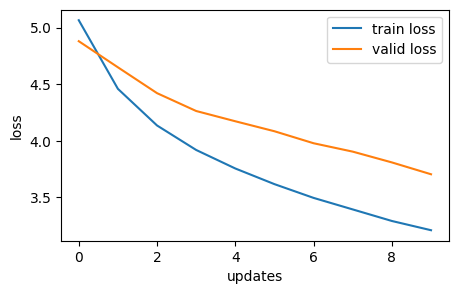

In [62]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [63]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.707 | Test PPL:  40.749 |


In [64]:
model

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(5174, 256)
    (lstm): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(6433, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=6433, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

## 7. Test on some random news

In [65]:
sample[0]

'Two young, White males are outside near many bushes.'

In [66]:
sample[1]

'Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.'

In [67]:
src_text = text_transform[SRC_LANGUAGE](sample[0]).to(device)
src_text

tensor([   2,   19,   25,   15, 1069,  842,   17,   56,   84,  331, 1623,    5,
           3], device='cuda:0')

In [68]:
trg_text = text_transform[TRG_LANGUAGE](sample[1]).to(device)
trg_text

tensor([   2,   21,   83,  262,   32,   89,   22,   91,    7,   16,  115,    0,
        2893,    4,    3], device='cuda:0')

In [69]:
src_text = src_text.reshape(-1, 1)  #because batch_size is 1

In [70]:
trg_text = trg_text.reshape(-1, 1)

In [71]:
src_text.shape, trg_text.shape

(torch.Size([13, 1]), torch.Size([15, 1]))

In [72]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output = model(src_text, trg_text, 0) #turn off teacher forcing

In [73]:
output.shape #trg_len, batch_size, trg_output_dim

torch.Size([15, 1, 6433])

Since batch size is 1, we just take off that dimension

In [74]:
output = output.squeeze(1)

In [75]:
output.shape

torch.Size([15, 6433])

We shall remove the first token since it's zeroes anyway

In [76]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([14, 6433])

Then we just take the top token with highest probabilities

In [77]:
output_max = output.argmax(1) #returns max indices

In [78]:
output_max

tensor([ 21,  83,  83,  32,  54, 136,   8,   0,   4,   3,   3,   3,   3,   3],
       device='cuda:0')

Get the mapping of the target language

In [79]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [80]:
for token in output_max:
    print(mapping[token.item()])

Zwei
junge
junge
Männer
stehen
zusammen
und
<unk>
.
<eos>
<eos>
<eos>
<eos>
<eos>


## Conclusion

It looks something is going on but the translation looks a bit off.  Let's try something else in the next part.